In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib as plt
import random

from typing import List, Tuple

In [2]:
# Cargamos el dataset de viento
datos = pd.read_excel('wind_data.xlsx')

# Visualizamos el dataset
datos.head()

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


La funcion $\theta$ esta definida como:

$$
\theta(i) = 6 + 2cos(2πi/365)
$$

In [3]:
def theta_function(i):
    return 6 + 2 * np.cos(2 * np.pi * i / 365)


El error en la regresión lineal, conocido como RMSE (raiz del error cuadratico medio o root mean squared error), está definido como:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

In [27]:
def calcular_error(Y, predicciones):

    n = len(Y)

    residuos = Y - predicciones
    varianza = np.sum(residuos**2) / n

    return np.sqrt(varianza)

# Ejercicio 1

Vamos a estimar los parámetros $\kappa$ y $\sigma$ para el regresion_vientoo de velocidad del viento regional utilizando un regresion_vientoo de regresion lineal.

La ecuación original es:

$$
S_{i+1} = S_i + \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_i
$$

Despejamos $S_i$ para obtener una forma adecuada para la regresión lineal:

$$
S_{i+1} - S_i = \kappa \Delta (\theta(t_i) - S_i) + \sigma \sqrt{\Delta} Z_i
$$

Reescribimos la ecuación en términos de $\beta$:

$$
Y = \beta_1 X  + \epsilon_i
$$

donde:
- $Y = S_{i+1} - S_i$
- $\beta_1 = \kappa \Delta$
- $\epsilon_i = \sigma \sqrt{\Delta} Z_i$

In [5]:
datos['Y'] = datos['regional wind'].diff()  # Calcula la diferencia entre días consecutivos

# Preparar X, que es theta_i - S_i 
datos['X'] = theta_function(datos["dia"]) - datos['regional wind'].shift(1)

# Eliminar los valores nulos generados por diff() y shift()
datos = datos.dropna(subset=['Y', 'X'])

datos.head()

,dia,regional wind,wind gap norte sur,Y,X
1,2,8.346296,0.181523,0.346296,-0.001185
2,3,10.062316,0.188643,1.716019,-0.348963
3,4,10.791337,0.071085,0.729021,-2.067055
4,5,10.754093,0.078442,-0.037244,-2.798740
5,6,10.771457,0.642188,0.017364,-2.764751


### Regresion Lineal para el modelo del viento regional

In [28]:
Y = datos['Y']
X = datos[['X']]

regresion_viento = LinearRegression()
regresion_viento.fit(X, Y)

B0 = regresion_viento.intercept_
B1 = regresion_viento.coef_[0]

print(f"B0: {B0}")
print(f"B1: {B1}")

delta = 1/365

#Estimamos kappa
kappa_estimado = B1 / delta

#Estimamos sigma
predicciones = regresion_viento.predict(X)

error = calcular_error(Y,predicciones)

sigma_estimado = error / np.sqrt(delta)

print(f"kappa: {kappa_estimado}")
print(f"sigma: {sigma_estimado}")

B0: -0.01097383275590443
B1: 0.29791558977455573
kappa: 108.73919026771284
sigma: 16.048374241071325


### Regresion Lineal para el modelo de diferencia de la velocidad del viento entre el norte y el sur

Vamos a estimar los parámetros $\beta$ y $\gamma$ para el regresion_vientoo de diferencia de la velocidad del viento entre el norte y el sur utilizando un modelo de regresion lineal.

La ecuación original es:

$$
D_{i+1} = D_i - \beta D_i \Delta + \gamma \sqrt{\Delta} W_i
$$

Despejamos $D_i$ para obtener una forma adecuada para la regresión lineal:

$$
D_{i+1} - D_i = - \beta \Delta D_i  + \gamma \sqrt{\Delta} W_i
$$

Reescribimos la ecuación en términos de $\beta$:

$$
H = \beta_1 G  + \epsilon_i
$$

donde:
- $H = D_{i+1} - D_i$
- $\beta_1 = -\beta \Delta$
- $\epsilon_i = \gamma \sqrt{\Delta} W_i$

In [7]:
# Preparar H
datos['H'] = datos['wind gap norte sur'].diff()

# Eliminar los valores nulos generados por diff()
datos = datos.dropna(subset = ('H'))

datos.head()

,dia,regional wind,wind gap norte sur,Y,X,H
2,3,10.062316,0.188643,1.716019,-0.348963,0.007120
3,4,10.791337,0.071085,0.729021,-2.067055,-0.117558
4,5,10.754093,0.078442,-0.037244,-2.798740,0.007358
5,6,10.771457,0.642188,0.017364,-2.764751,0.563745
6,7,9.527320,0.018175,-1.244136,-2.785959,-0.624012


In [22]:
G = datos[['wind gap norte sur']]
H = datos['H']

regresion_2 = LinearRegression()
regresion_2.fit(G,H)

B0_2 = regresion_2.intercept_
B1_2 = regresion_2.coef_[0]

print(f"B0: {B0_2}")
print(f"B1: {B1_2}")

#Estimamos beta
beta_estimado = -B1_2 / delta

#Estimamos gamma

predicciones_gap = regresion_2.predict(G)

error_gap = calcular_error(H,predicciones_gap)

gamma_estimado = error_gap / np.sqrt(delta)

print(f"beta: {beta_estimado}")
print(f"gamma: {gamma_estimado}")

B0: -0.004057305907658576
B1: 0.13254466625549
beta: -48.37880318325385
gamma: 10.091915756839064


# Ejercicio 2

In [9]:
def generar_viento_regional(kappa, sigma, T):
    camino_viento = np.zeros(T)
    camino_viento[0] = datos['regional wind'].iloc[0] #PREGUNTAR ESTO

    for i in range(1, T):
        Z = np.random.normal(0, 1)
        camino_viento[i] = camino_viento[i-1] + kappa * (theta_function(i) - camino_viento[i-1]) * 1/T + sigma * np.sqrt(1/T) * Z

    return camino_viento

def generar_gap_norte_sur(beta, gamma, T):
    camino_gap = np.zeros(T)
    camino_gap[0] = datos['wind gap norte sur'].iloc[0] #PREGUNTAR ESTO

    for i in range(1, T):
        W = np.random.normal(0, 1)
        camino_gap[i] = camino_gap[i-1] - beta * 1/T * camino_gap[i-1] + gamma * np.sqrt(1/T) * W

    return camino_gap


In [11]:
import matplotlib.pyplot as plt

#Generamos 2 caminos con T = 365 uno para cada molino
T = 365

simular_viento = generar_viento_regional(kappa_estimado,sigma_estimado,T)

simular_gap = generar_gap_norte_sur(beta_estimado,gamma_estimado,T)

simulacion_norte = simular_viento + simular_gap/2

simulacion_sur = simular_viento - simular_gap/2


$$
\text{Simulación Norte} = S_i + \frac{D_i}{2}
$$

$$
\text{Simulación Sur} = S_i - \frac{D_i}{2}
$$

Luego, si tomamos el promedio:

$$
\frac{\left(S_i + \frac{D_i}{2}\right) + \left(S_i - \frac{D_i}{2}\right)}{2} = S_i
$$

Simplificando:

$$
\frac{S_i + \frac{D_i}{2} + S_i - \frac{D_i}{2}}{2} = \frac{2S_i}{2} = S_i
$$

### Grafico comparativo del viento regional real vs el simulado

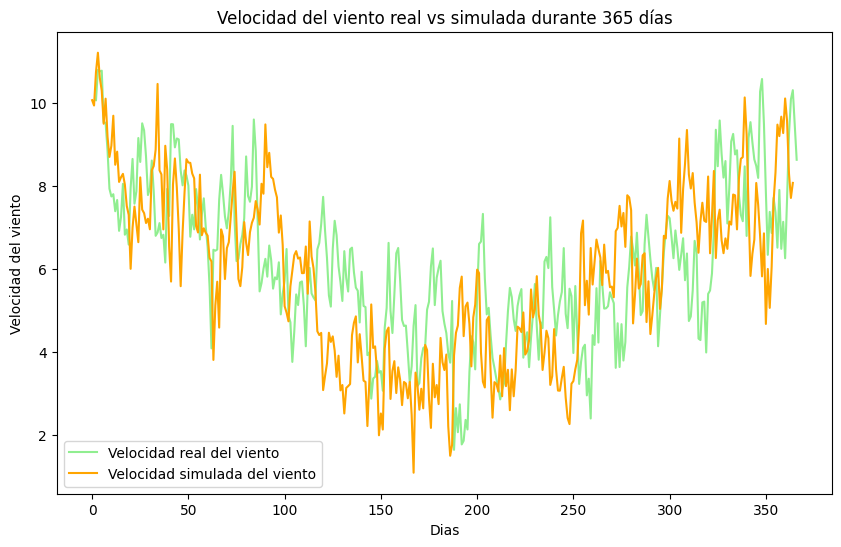

In [12]:
import matplotlib.pyplot as plt

# Graficar la velocidad del viento
plt.figure(figsize=(10, 6))
plt.plot(datos['regional wind'][:T], color='lightgreen', label='Velocidad real del viento')
plt.plot(simular_viento, color='orange', label='Velocidad simulada del viento')

# Añadir etiquetas y título
plt.xlabel('Dias')
plt.ylabel('Velocidad del viento')
plt.title('Velocidad del viento real vs simulada durante 365 días')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Vemos que en el largo plazo, hay una correlacion positiva entre ambos, por lo que resulta razonable pensar que el camino simulado se parece al camino real

### Grafico comparativo de la diferencia de velocidad del viento entre el norte y el sur real vs la simulada

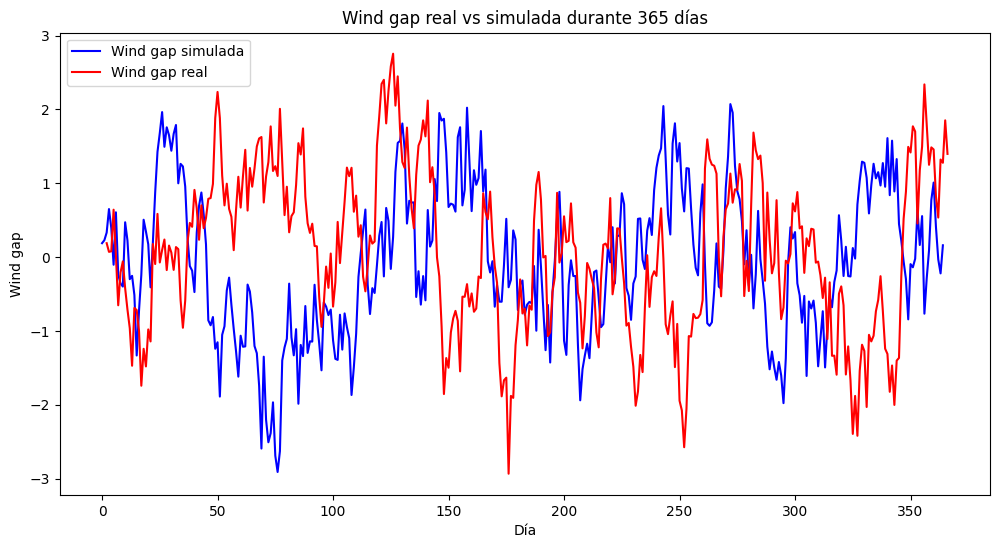

In [13]:
# Graficar las simulaciones
plt.figure(figsize=(12, 6))
plt.plot(simular_gap, color='blue', label='Wind gap simulada')
plt.plot(datos["wind gap norte sur"][:T], color='red', label='Wind gap real')

plt.xlabel('Día')
plt.ylabel('Wind gap')
plt.title('Wind gap real vs simulada durante 365 días')
plt.legend()
plt.show()


### Gráfico comparativo de la velocidad simulada del viento para los molinos norte y sur

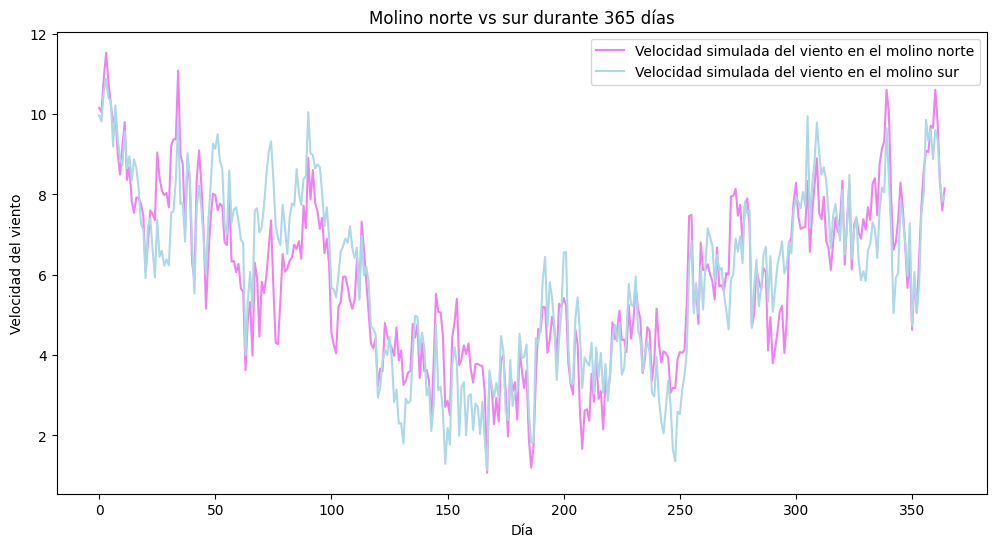

In [14]:
# Graficar las simulaciones
plt.figure(figsize=(12, 6))
plt.plot(simulacion_norte, color='violet', label='Velocidad simulada del viento en el molino norte')
plt.plot(simulacion_sur, color='lightblue', label='Velocidad simulada del viento en el molino sur')

plt.xlabel('Día')
plt.ylabel('Velocidad del viento')
plt.title('Molino norte vs sur durante 365 días')
plt.legend()
plt.show()

Si bien hay periodos dentro del corto plazo donde la correlacion no es positiva, en el largo plazo ambos caminos se expanden de la misma manera, con correlación positiva

# Ejercicio 3

In [32]:
def simular_rotura(p):
    return 1 if random.uniform(0,1) < p else 0

def calcular_VAN(T, viento, k):
    delta = 1/T
    S = viento
    activo = False
    VAN = 0
    VAN_diario = []

    estado_molino = []
    rotura = []

    for i in range(1, T):

        estado_molino.append(activo)

        probabilidad_rotura = 0.25*(S[i]**2)*delta
        if(activo):
            esta_roto = simular_rotura(probabilidad_rotura)

            if(esta_roto):
                VAN -= 200000
                activo = False
                rotura.append(1)
            
            else:

                rotura.append(0)

                if(S[i] >= k):
                    activo = False
                    VAN -= 1000

                else:
                    VAN += 1000 * S[i]
        
        else:

            if(S[i] < k):
                activo = True
                VAN += 1000 * S[i]
        
            rotura.append(0)

        VAN_diario.append(VAN)
    
    return VAN_diario, estado_molino, rotura

def simular_ambos_molinos(sim_norte, sim_sur, T, k) -> List:

    VAN_molino_norte,estados_molino_norte,roturas_molino_norte = calcular_VAN(T,sim_norte,k)

    info_molino_norte = (VAN_molino_norte,estados_molino_norte,roturas_molino_norte)

    VAN_molino_sur,estados_molino_sur,roturas_molino_sur = calcular_VAN(T, sim_sur,k)

    info_molino_sur = (VAN_molino_sur,estados_molino_sur,roturas_molino_sur)

    return [info_molino_norte, info_molino_sur]

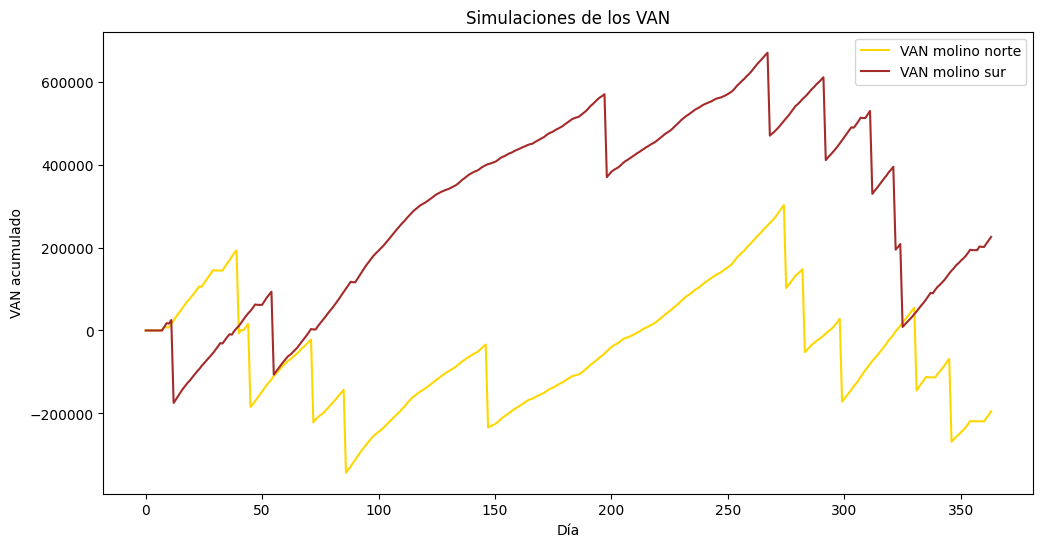

In [37]:
simulacion_ambos_molinos = simular_ambos_molinos(simulacion_norte,simulacion_sur,T,9)

simular_VAN_molino_norte = simulacion_ambos_molinos[0][0]

simular_VAN_molino_sur = simulacion_ambos_molinos[1][0]

# Graficar las simulaciones
plt.figure(figsize=(12, 6))
plt.plot(simular_VAN_molino_norte, color='gold', label='VAN molino norte')
plt.plot(simular_VAN_molino_sur, color='brown', label='VAN molino sur')

plt.xlabel('Día')
plt.ylabel('VAN acumulado')
plt.title('Simulaciones de los VAN')
plt.legend()
plt.show()

# Ejercicio 4

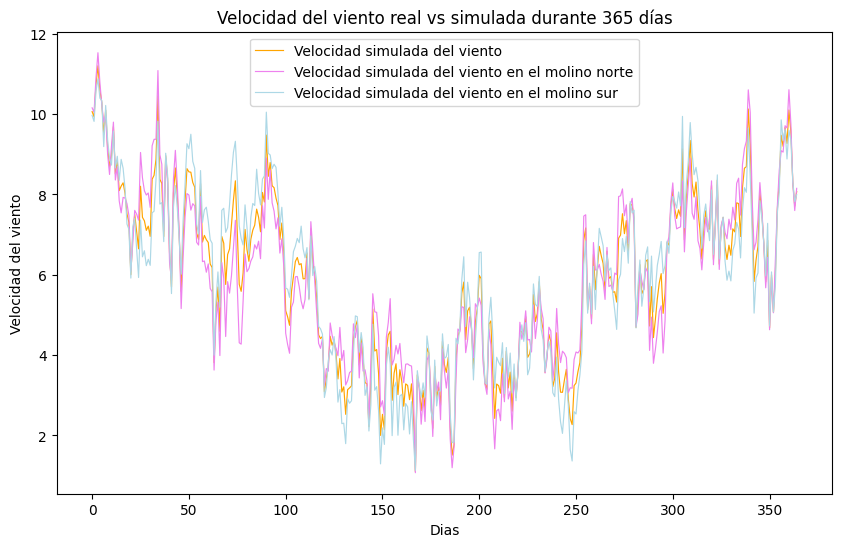

In [17]:
# Graficar la velocidad del viento
plt.figure(figsize=(10, 6))
plt.plot(simular_viento, color='orange', label='Velocidad simulada del viento', linewidth = 0.85)
plt.plot(simulacion_norte, color='violet', label='Velocidad simulada del viento en el molino norte', linewidth = 0.85)
plt.plot(simulacion_sur, color='lightblue', label='Velocidad simulada del viento en el molino sur', linewidth = 0.85)

# Añadir etiquetas y título
plt.xlabel('Dias')
plt.ylabel('Velocidad del viento')
plt.title('Velocidad del viento real vs simulada durante 365 días')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

En el gráfico podemos observar como las 3 simulaciones se expanden de manera simetrica a traves del tiempo, esto nos lleva a pensar que los modelos implementados anteriormente son fieles a los datos proporcionados, mostrando una correlacion de largo plazo positiva.


A CHEQUEAR REY

# Ejercicio 5

El VAN esperado se calcula como el promedio de los VANs simulados:
$$
\text{VAN esperado} = \frac{1}{N} \sum_{j=1}^N \text{VAN}_j
$$

donde:
- N es el número total de simulaciones.
- $\text{VAN}_j$ es el VAN del j-ésimo camino simulado.


In [18]:
def VAN_norte_esperado(k, N):
    simulaciones_VAN_norte = []

    for i in range(N):
        simular_viento = generar_viento_regional(kappa_estimado,sigma_estimado,365)
        simular_gap = generar_gap_norte_sur(beta_estimado,gamma_estimado,365)
        
        camino_norte = simular_viento + simular_gap/2

        VAN_norte = calcular_VAN(T, camino_norte, 8)

        simulaciones_VAN_norte.append(VAN_norte[-1])
    
    VAN_esperado = np.mean(simulaciones_VAN_norte)
    res = (VAN_esperado, simulaciones_VAN_norte)

    return(res)
    

def VAN_sur_esperado(k, N):
    simulaciones_VAN_sur = []

    for i in range(N):
        simular_viento = generar_viento_regional(kappa_estimado,sigma_estimado,365)
        simular_gap = generar_gap_norte_sur(beta_estimado,gamma_estimado,365)

        camino_sur = simular_viento + simular_gap/2

        VAN_sur = calcular_VAN(T, camino_sur, 8)

        simulaciones_VAN_sur.append(VAN_sur[-1])
    
    VAN_esperado = np.mean(simulaciones_VAN_sur)
    res = (VAN_esperado, simulaciones_VAN_sur)

    return(res)



El error de estimación del VAN esperado se calcula en dos pasos:

1. **Calcular la Desviación Estándar de los VANs Simulados**:

   La fórmula para la desviación estándar $\sigma_{\text{VAN}}$ es:
   $$
   \sigma_{\text{VAN}} = \sqrt{\frac{1}{N-1} \sum_{j=1}^N (\text{VAN}_j - \text{VAN esperado})^2}
   $$

   Donde:
   - N es el número total de simulaciones.
   - $\text{VAN}_j$ es el VAN del j-ésimo camino simulado.
   - $\text{VAN esperado}$ es el promedio de los VANs simulados.

2. **Calcular el Error Estándar del VAN Esperado**:

   La fórmula para el error estándar es:
   $$
   \text{Error estándar} = \frac{\sigma_{\text{VAN}}}{\sqrt{N}}
   $$

   Donde:
   - $\sigma_{\text{VAN}}$ es la desviación estándar de los VANs simulados.
   - N es el número total de simulaciones.


In [21]:
def estimar_error_VAN(VANs_simulados):
    # Supongamos que 'vans' es una lista o array de VANs simulados
    datos = VANs_simulados

    # Calcular la desviación estándar de los VANs simulados
    desviacion_estandar = np.std(datos, ddof=1)  # ddof=1 para obtener la desviación estándar muestral

    # Calcular el error estándar
    error_estandar = desviacion_estandar / np.sqrt(len(datos))

    return error_estandar

print(estimar_error_VAN(VAN_norte_esperado(8, 10000)[1]))

5099.026233535672


# Ejercicio 6

Queremos encontrar el valor k